In [1]:
import matplotlib.pyplot as plt
import csv
import pandas as pd

from lib.lib_fluxes import *

# U239 and Np239 fluxes

## Importing the BESTIOLE data

In [2]:
breeding_isotopes_txtfile_format = ['u239', 'np239']

spectrum_source = 'bestiole'

bestiole_breeding_spectra_data = []
bestiole_breeding_spectra = []

for fi in breeding_isotopes_txtfile_format:
    spec = get_spectrum(f"fluxData/{spectrum_source}_{fi}.txt")
    bestiole_breeding_spectra_data.append(spec)

    bestiole_breeding_spectra.append(CubicSpline(*spec, extrapolate=False))


Text(0, 0.5, 'Rate (/fission/MeV)')

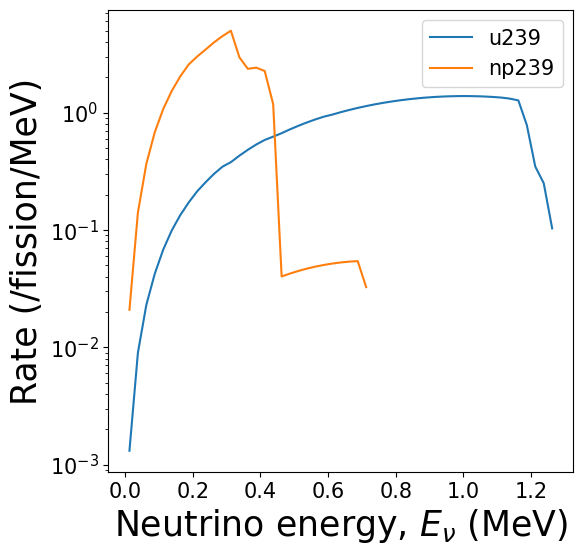

In [3]:
fig, ax = plt.subplots(figsize=(6,6))

for fi, spec_data in zip(breeding_isotopes_txtfile_format, bestiole_breeding_spectra_data):
    ax.plot(spec_data[0]/MeV, spec_data[1]*MeV, label=fi)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.tick_params(labelsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/fission/MeV)", fontsize=25)

## Comparing to the CONFLXUX data

These results are taken from spectra generated using CONFLUX, a new program made by a team in the US associated with MINER that Jay has contact with (through Bryce Littlejohn)

They generated spectra for a pressurised water reactor midway through its cycle, with and without U239/Np239. So, taking the difference of the two spectra should result in the spectra for just U239 and Np239

In [4]:
CONFLUX_hfir_per_sec_df = pd.read_csv('./spectra/hfir_per_sec.csv')
CONFLUX_breeding_spectra_df = pd.read_csv('./spectra/breeding_U239_Np239.dat', sep='\t', header=None)

CONFLUX_nu_energies_MeV = np.array(CONFLUX_hfir_per_sec_df.e) # The units are MeV
CONFLUX_hfir_spectrum = np.array(CONFLUX_hfir_per_sec_df.spectrum) # The units are ?/second/MeV for a ?GW reactor

CONFLUX_nu_energies = np.array(CONFLUX_breeding_spectra_df[0]) # The variable name does not specify units b/c it is in GeV
CONFLUX_breeding_spectrum = np.array(CONFLUX_breeding_spectra_df[1])



I want to test what HFIR per sec actually is a spectrum of: is it an 85 MW HFIR reactor (with pure U235 as fuel?) or a GW pressurised water reactor halfway through its cycle? Let's compare

Text(0, 0.5, 'Rate (/second/MeV)')

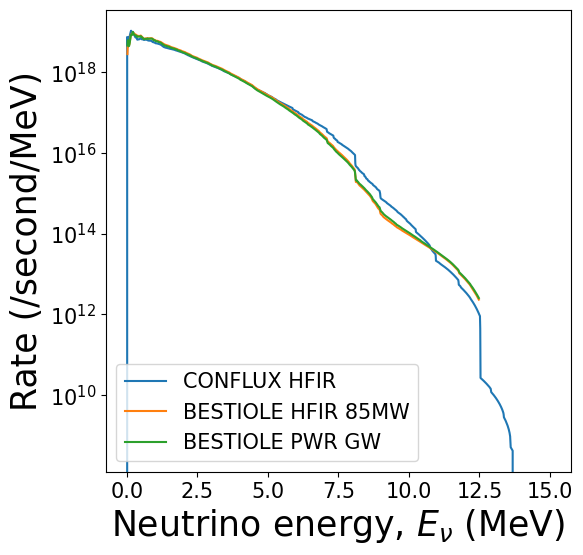

In [74]:
fig, ax = plt.subplots(figsize=(6,6))

BESTIOLE_85MW_HFIR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [1,0,0,0])(CONFLUX_nu_energies)
BESTIOLE_GW_PWR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [53,8,32,7])(CONFLUX_nu_energies)

ax.plot(CONFLUX_nu_energies_MeV, CONFLUX_hfir_spectrum, label='CONFLUX HFIR')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_85MW_HFIR_spec*SECOND*MeV, label='BESTIOLE HFIR 85MW')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_GW_PWR_spec*SECOND*MeV, label='BESTIOLE PWR GW')

ax.set_yscale('log')
ax.tick_params(labelsize=15)
# ax.set_ylim(1e0, 1e30)
# ax.set_xlim(0,2.5)

ax.legend(fontsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/second/MeV)", fontsize=25)

So it's definitely an 85MW reactor - however, it's a bit tricky to disentangle whether it's HFIR (pure U235) or a PWR mix, as they seemingly coincidentally have very similar neutrino spectra. We'll show this by taking ratios of the given fluxes to the CONFLUX flux

Text(0, 0.5, 'Rate/CONFLUX rate')

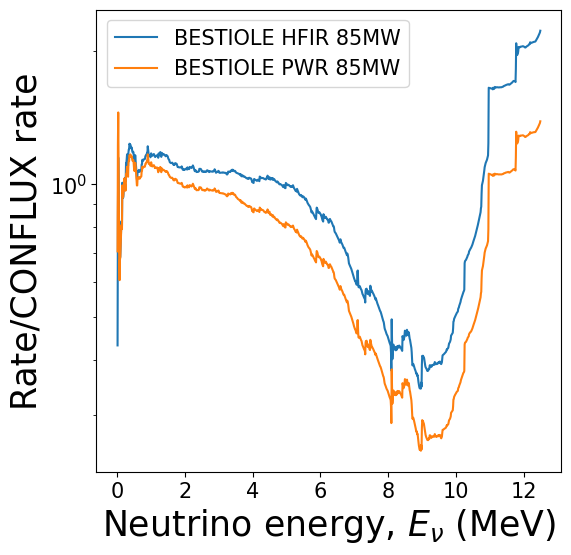

In [73]:
fig, ax = plt.subplots(figsize=(6,6))

BESTIOLE_85MW_HFIR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [1,0,0,0])(CONFLUX_nu_energies)
BESTIOLE_GW_PWR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [53,0,47,0])(CONFLUX_nu_energies)

# ax.plot(CONFLUX_nu_energies_MeV, CONFLUX_hfir_spectrum, label='CONFLUX HFIR')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_85MW_HFIR_spec*SECOND*MeV/CONFLUX_hfir_spectrum, label='BESTIOLE HFIR 85MW')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_GW_PWR_spec*SECOND*MeV/CONFLUX_hfir_spectrum, label='BESTIOLE PWR 85MW')

ax.set_yscale('log')
ax.tick_params(labelsize=15)

ax.legend(fontsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate/CONFLUX rate", fontsize=25)

### Comparing the CONFLUX breeding isotopes and the BESTIOLE breeding isotopes

First, I need to make code to combine the two breeding spectra (U239 and Np239)

At first, I'll just assume that they have equal fission rates, but I will need to think about that properly

In [106]:
BESTIOLE_breeding_spec_nu_energies = np.linspace(0, 1.5*MeV, 100)

BESTIOLE_breeding_spectrum_GW = []

thermal_power = 0.011*GIGAWATT

beta_decay_energy_u239 = 1.2617*MeV
beta_decay_energy_np239 = 0.7229*MeV

for Enu in BESTIOLE_breeding_spec_nu_energies:
    bestiole_u239 = bestiole_breeding_spectra[0](Enu)
    if np.isnan(bestiole_u239):
        bestiole_u239 = 0
    bestiole_np239 = bestiole_breeding_spectra[1](Enu)
    if np.isnan(bestiole_np239):
        bestiole_np239 = 0

    combined_spectrum_GW = bestiole_u239 * thermal_power/beta_decay_energy_u239 + bestiole_np239 * thermal_power/beta_decay_energy_np239

    BESTIOLE_breeding_spectrum_GW.append(combined_spectrum_GW)

Text(0, 0.5, 'Rate (/second/MeV)')

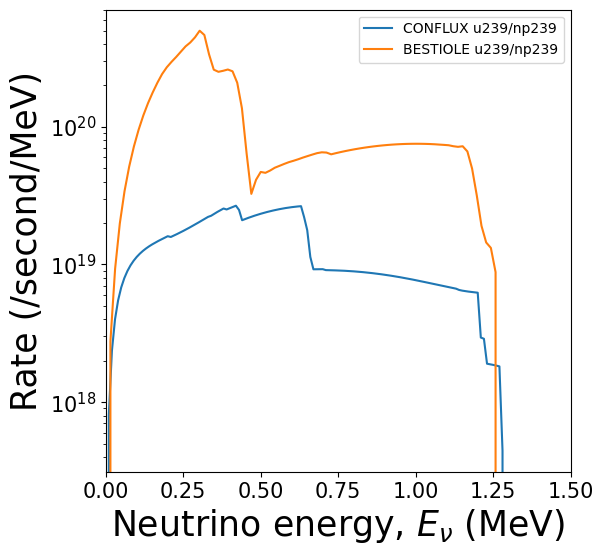

In [109]:
fig, ax = plt.subplots(figsize=(6,6))

# for fi, spec_data in zip(breeding_isotopes_txtfile_format, bestiole_breeding_spectra_data):
#     ax.plot(spec_data[0]/MeV, spec_data[1], label='BESTIOLE ' + fi)

ax.plot(CONFLUX_nu_energies_MeV, CONFLUX_breeding_spectrum*SECOND*MeV, label='CONFLUX u239/np239')

ax.plot(BESTIOLE_breeding_spec_nu_energies/MeV, np.array(BESTIOLE_breeding_spectrum_GW)*SECOND*MeV, label='BESTIOLE u239/np239')

ax.legend(fontsize=10)

ax.set_yscale('log')
ax.tick_params(labelsize=15)

ax.set_xlim(0,1.5)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/second/MeV)", fontsize=25)